# Bad Pixels

Initially written for the bootcamp at SLAC Nov 2018 by Imran, Andrew, and Andrés 

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          16.0-1-g3bbe181+31 	current w_2018_45 setup


## Imports

In [2]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection
from lsst.ip.isr import isrFunctions
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.image as afwImage

from lsst.obs.lsst.ts8 import Ts8Mapper


plt.style.use('seaborn-poster') #make the plots look nice

In [3]:
plt.style.use('seaborn-poster') #needs to be executed twice for some reason

## LSST Stack BPM

In this notebook we will use the DM stack emulate the workflow from EOTest to create a bad pixel mask to mask out hot pixels. In our first step we will create a butler instance to grab a master dark that was kindly prepared by Merlin Fisher-Levine.

In [4]:
#Get master dark and master flat using the DM butler

In [5]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
dId_dark = {'visit': 258334666, 'detector': 4}
dark = butler.get('dark', **dId_dark)

The visit numbers in the previous cell are obtained by using the butler to querythe meta data. In the next cell, you may replace 'raw' with 'DARK', and use the first ID when creating a data ID to pass the butler.

In [6]:
print(butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT'})) #Change type to 'DARK' to get ID of a dark file. 

[258333657, 258333691, 258333725, 258333759, 258334082, 258334094, 258339739, 258339769, 258339807, 258339839, 258339875, 258339908, 258339945, 258339976, 258340014, 258340047, 258340086, 258340120, 258340159, 258340176, 258340202, 258340220, 258340244, 258340265, 258340290, 258340314, 258340341, 258340363, 258340392, 258340416, 258340449, 258340477, 258340511, 258340542, 258340581, 258340618, 258340662, 258340707, 258340758, 258340811, 258340873, 258340939, 258341017, 258341101, 258341198, 258341305, 258341426, 258341550, 258341693, 258341830, 258341990, 258342143, 258342307, 258342465, 258342632, 258342795, 258342968, 258343136, 258343313, 258343485, 258343670, 258343846, 258344037, 258344222, 258344422, 258344616, 258344826, 258345029, 258345246, 258345458, 258345684, 258345905, 258346139, 258346369, 258346613, 258346852, 258347105, 258347351, 258347613, 258347868, 258348138, 258348402, 258348695, 258348982, 258350677, 258350700, 258350725, 258350751, 258350774, 258350797, 258350822

Now we will create a python object to do our analysis. The object itself has a run method, that calls its other methods in sequence. Below we describe what is hapening with some pseudo code


1. in each amp, calculate the 99.99th percentile of the pixel values from the dark. this defines a threshold above which pixels will be considered bright, and subsequently masked
2. amp by amp, run threshold detection using the threshold from the previous step. this identifies pixels we will consider hot
3. use the footprints from the previous step and make them into `defect list` objects using the DM ISR framework
4. update the mask plane of the master dark using the defect list created in the previous step

In [7]:
class bright_pixels():
    def __init__(self):
        BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
        self.butler = Butler(BOOTCAMP_REPO_DIR)
        self.dark = self.butler.get('dark', dataId={'visit': 258334666, 'detector': 4})
        self.masked_image = self.dark.getMaskedImage()
        self.percentile = 99.9
        self.colthreshold = 20
        
    def run(self,):
        # determine threshold values per amp
        self.thresholds = self.dark_thresh(self.dark, self.percentile)
        # plot out the pixel distributions of the amps
        self.plot_amp_hist(self.dark, self.thresholds)
        # mask hot pixels in place
        self.mask_bright_pixels(self.dark, self.thresholds)
        self.mask_bright_columns(self.dark, self.colthreshold)
        return
        
    def dark_thresh(self, dark, percentile):
        '''
        rudimentary place holder to identify bright pixels.
        looks at the distribution of pixel values from the dark amp by amp, and calculates the 
        self.percentile of the distribution
        input 
        dark : master dark, exposure object
        percentile : int, percentile above which to consider a pixel hot 
        returns
        thresh : dictionary with the calculated percentile thresholds for each amp
        '''
        thresh = {}
        #loop over amps
        for amp in dark.getDetector():
            #calculate nth percentile 
            name = amp.getName()
            work_img = self.masked_image[amp.getBBox()]
            #maybe there is a more stack like way to do this
            threshold = numpy.percentile(work_img.getImage().array.flatten(), percentile)
            thresh[name] = threshold #threhs value is in DN
        return thresh

    def plot_amp_hist(self, dark, thresh):
        '''
        make a histogram of the distribution of pixel values for each amp
        also show its self.percentile cut
        '''
        f, ax = plt.subplots(nrows=4, ncols=4, sharex='col', sharey='row')
        amps = dark.getDetector()
        for amp, a in zip(amps, ax.flatten()):
            threshold = thresh[amp.getName()]
            work_img_data = self.masked_image[amp.getBBox()].getImage().array.flatten()
            a.hist(work_img_data, histtype='step', bins=numpy.linspace(-0.1,.1,100), lw=3)
            a.axvline(threshold, c='k')
            a.set_yscale('log')
        return
    
    def mask_bright_pixels(self, dark, thresh):
        '''
        useing the thresholds for each amp, mask pixels that have been 
        tagged as bright. This is done in place on the dark
        input
        dark: master dark, afw exposure object
        output
        dark: the same master dark but now the mask plane has been updated inplace
        '''
        #loop over amps
        masked_img = dark.getMaskedImage()
        for amp in dark.getDetector():
            name = amp.getName()
            detect_thresh = thresh[name]
            # create threshold object
            Threshold = afwDetection.Threshold(detect_thresh)
            work_img = self.masked_image[amp.getBBox()]
            footprints = afwDetection.FootprintSet(work_img, Threshold).getFootprints()
            defects = isrFunctions.defectListFromFootprintList(footprints)
            isrFunctions.maskPixelsFromDefectList(masked_img, defects)

        return
    
    def mask_bright_columns(self, dark, col_thresh):
        '''
        place holder function for now.
        find contiguous bright pixels in columns. If a column contains col_thresh
        contiguous hot pixels, then mask the entire column
        '''
        return

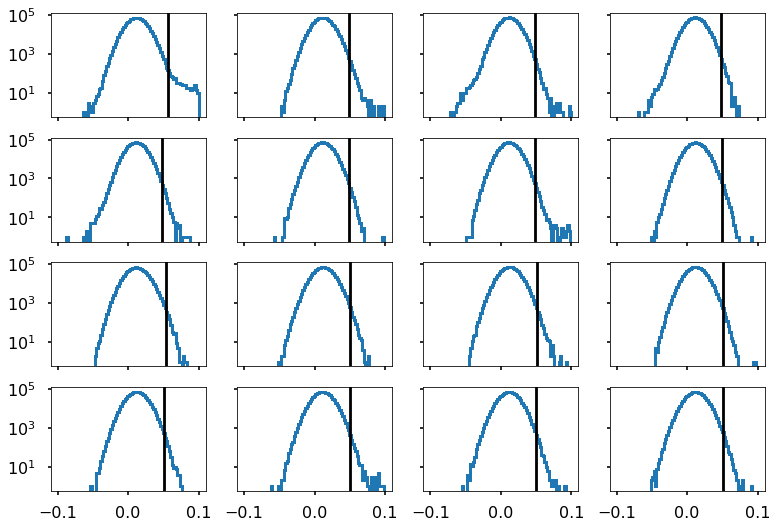

In [8]:
# create a bright pixel object and run our analysis
bpm = bright_pixels()
bpm.run()

In the plot above, we show the distribution of pixel values for all the amps in the master dark (blue) and the 99.99th percentile (black). You can see by eye some amps have extended right tails (upper left pannel), indicating they contain hot pixels. At the moment, we consider *all* pixels above the 99.99th percentile to be hot. Of course, statistically some pixels which have no defects will live in the 99.99th percentile. Our threshold method is a place holder we settled on for the moment.

Below, we show the calculated bad pixel mask. Masked pixels are yellow. In the upper right you can see we caught a bright column. To the right of our bright column, some cross talk has caused a secondary bright column. The remaining yellow pixels may very well not defective at all, and instead simply pixels that live in the 99.99th percentile

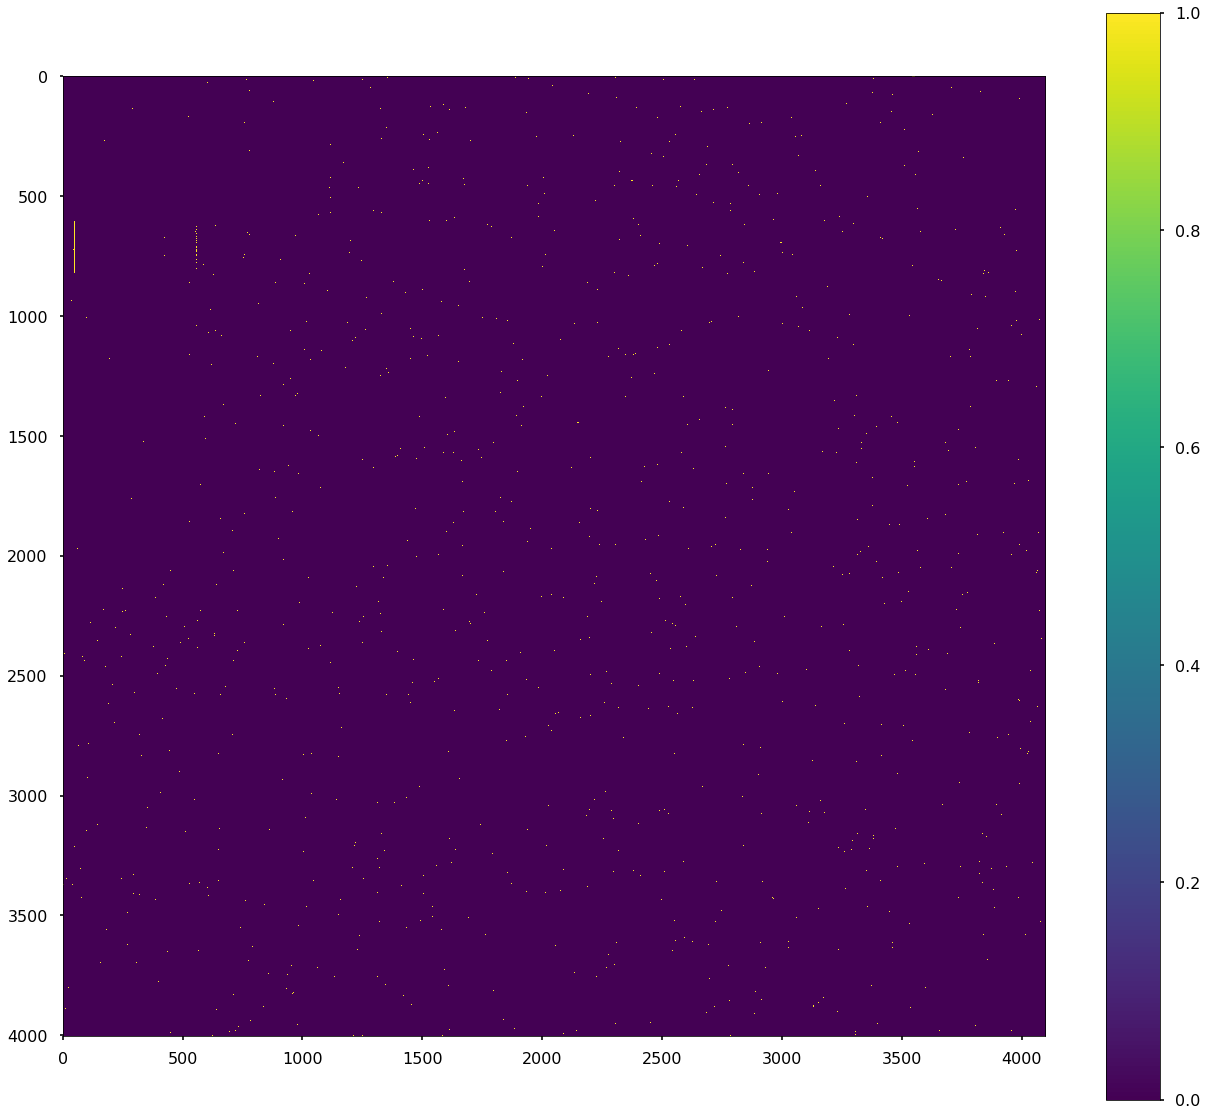

In [9]:
plt.figure(figsize=(22,20))
plt.imshow(bpm.masked_image.mask.array, vmin=0, vmax=1)
plt.colorbar()

## EOTest

Now we will grab the bad pixel mask made from EOTest so we might compare ours

### Read in the bad pixel mask from eotest

In [10]:
amps = {}
for i in range(16):
    exp = afwImage.ExposureU('/project/bootcamp/data/LCA-11021_RTM-007/7086/bright_defects_raft/v0/44990/S11/E2V-CCD250-195_bright_pixel_mask.fits[%i]'%(i))
    md = exp.getMetadata()
    amps[md.get('EXTNAME')] = exp

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Use getArray or getScalar instead


In [11]:
mapper = Ts8Mapper()
detector = mapper.camera['R00_S11']
outIm = afwImage.ImageU(detector.getBBox())

In [12]:
for key, item in amps.items():
    amp_name = 'C%s'%(key[-2:])
    amp = detector[amp_name]
    amp_im = amps[key].getMaskedImage().getImage()
    arr = amp_im[amp.getRawDataBBox()].getArray()
    if amp.getRawFlipX():
        arr = numpy.flip(arr, axis=1)
    if amp.getRawFlipY():
        arr = numpy.flip(arr, axis=0)
    box = amp.getBBox()
    outView = outIm[box].getArray()
    outView[:] = arr

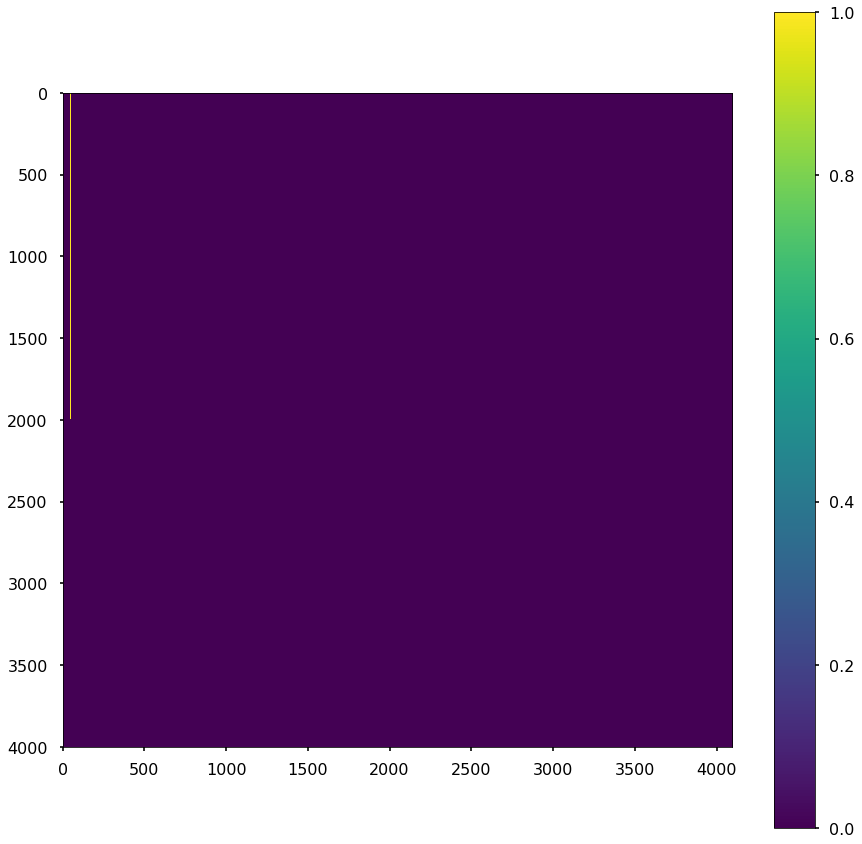

In [13]:
eo_bpm = outIm.getArray()
plt.figure(figsize=(15,15))
plt.imshow(eo_bpm)
plt.colorbar()

Above, we show the EOTest bad pixel mask. Notice both masks have identified the feature in the upper left. The EOTest code has the functionality to consider the entire column bad, and mask it out accordingly. We were not able to add this functionality into our code, but we certainly think it is correct to do so. Additionally, the EOTest mask missed the cross talk feature, but does not have the speckling of masked pixels we had. 

After digging into the code a bit, EOTest used a procedure based on the gain, exposure time, and a threshold in uits of electron per second per adu. Because of time constraints, and the fact that our master dark did not contain this information, so we were unable to emulate this technique

Now we show a zoom in of the hot column from our BPM and the EOTest BPM for a side by side comparison.

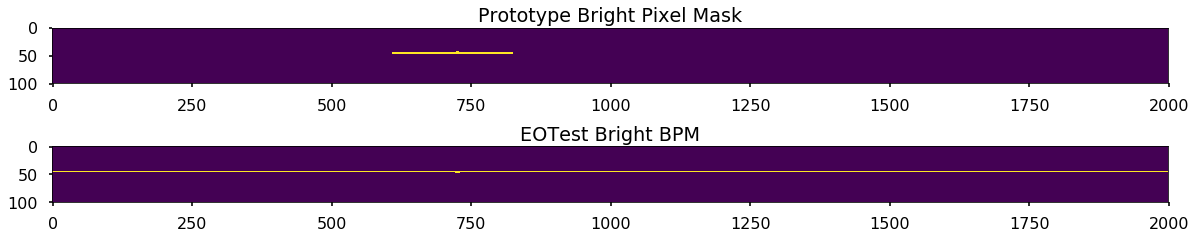

In [14]:
plt.figure(figsize=(20,4))
plt.subplot(211),plt.title('Prototype Bright Pixel Mask')
plt.imshow(bpm.masked_image.mask.array[0:2000, 0:100].T)
plt.subplot(212),plt.title('EOTest Bright BPM')
plt.imshow(eo_bpm[0:2000, 0:100].T)